In [1]:
import sys
print(sys.path)
sys.path.append("../KE/")
print(sys.path)

['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages']
['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages', '../KE/']


In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from KE.classifier.prepare import split_dataset
from KE.dataclean import tables

In [4]:
import random
import numpy as np
import os
#import tensorflow as tf
#import torch

SEED_VALUE = 62

# Seed for Python's built-in random module
random.seed(SEED_VALUE)

# Seed for NumPy
np.random.seed(SEED_VALUE)

# Seed for TensorFlow
#tf.random.set_seed(SEED_VALUE)

# Seed for PyTorch
#torch.manual_seed(your_seed_value)
#torch.cuda.manual_seed_all(SEED_VALUE)

# Environment-level seed (less common)
#os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

In [33]:
data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")

data_nodes = pd.read_csv("../data/merged/merged-kg_nodes.tsv", header=0, sep="\t")

/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_16870/4098560242.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")
/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_16870/4098560242.py:3: DtypeWarning: Columns (3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_nodes = pd.read_csv("../data/merged/merged-kg_nodes.tsv", header=0, sep="\t")


In [6]:
data

,id,subject,predicate,object,relation,provided_by,knowledge_source,meta,primary_knowledge_source
0,urn:uuid:8fc21838-7a64-4fa3-b80e-308f7ae872fe,NCBITaxon:1,biolink:subclass_of,BFO:0000040,rdfs:subClassOf,NaN,Graph,NaN,NaN
1,urn:uuid:925167a8-ce9c-40b6-8a26-c894b80563c3,NCBITaxon:10,biolink:subclass_of,NCBITaxon:1706371,rdfs:subClassOf,NaN,Graph,NaN,NaN
2,urn:uuid:d4b89149-93aa-4777-b865-2b795655a222,NCBITaxon:100,biolink:subclass_of,NCBITaxon:99,rdfs:subClassOf,NaN,Graph,NaN,NaN
3,urn:uuid:0af25ff0-8a22-4ad2-a347-89f2127fcbd5,NCBITaxon:100,biolink:occurs_in,mediadive.medium:7,BAO:0002924|BAO:0002924,NaN,Graph,NaN,"['bacdive:17385', 'bacdive:17390']"
4,urn:uuid:db204326-7a8e-4645-b9e9-04984629cea0,NCBITaxon:100,biolink:occurs_in,mediadive.medium:J346,BAO:0002924,NaN,Graph,NaN,bacdive:17385
...,...,...,...,...,...,...,...,...,...
1538345,urn:uuid:32b8b570-9ab7-47c1-9238-3881120bd6ea,NCBITaxon:147448,biolink:has_phenotype,traits.cell_shape_enum:coccus,RO:0002200,NaN,Graph,NaN,NaN
1538346,urn:uuid:dae0f3e0-bb65-4b77-b9da-f27347458699,NCBITaxon:147448,biolink:capable_of,ECOCORE:00000177,RO:0002215,NaN,Graph,NaN,NaN
1538347,urn:uuid:d9f2c769-9f20-4ebe-9171-809ce7633df2,NCBITaxon:1240726,biolink:has_phenotype,traits.cell_shape_enum:bacillus,RO:0002200,NaN,Graph,NaN,NaN
1538348,urn:uuid:35631e51-6b60-4337-8260-cd56f9f57278,NCBITaxon:1240783,biolink:has_phenotype,traits.cell_shape_enum:bacillus,RO:0002200,NaN,Graph,NaN,NaN


In [7]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,NCBITaxon:1,BFO:0000040
1,NCBITaxon:10,NCBITaxon:1706371
2,NCBITaxon:100,NCBITaxon:99
3,NCBITaxon:100,mediadive.medium:7
4,NCBITaxon:100,mediadive.medium:J346
...,...,...
1538345,NCBITaxon:147448,traits.cell_shape_enum:coccus
1538346,NCBITaxon:147448,ECOCORE:00000177
1538347,NCBITaxon:1240726,traits.cell_shape_enum:bacillus
1538348,NCBITaxon:1240783,traits.cell_shape_enum:bacillus


In [8]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('mediadive.medium:')]
data_pairs_clean.to_csv("NCBITaxon_to_medium.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(32513, 2)

In [9]:
#add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(37667, 2)

In [10]:
#add closure

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(2446, 2)

In [11]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrate:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape_enum:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('data_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(47187, 2)

In [28]:
data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_df_pairs['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_df_pairs.pivot(index='subject', columns='object', values='Value')

# Step 3: Fill NaN values with 0 to indicate no relationship
data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_oxidation,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
subject_object_mapping = data_pairs_clean.set_index('subject')['object'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
data_df['medium'] = data_df.index.map(subject_object_mapping)


In [30]:
data_df['medium'].isna().sum()

20368

In [31]:
data_df_orig = data_df.copy()

data_df = data_df[data_df['medium'].notna()]
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:81
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:668
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [16]:
#data_pairs_clean = tables.rows_ad_cols_quant_filter(data_pairs)
#require at least 10 examples per class
data_df_clean = data_df.groupby('medium').filter(lambda x : len(x)>9)

In [17]:
data_df_clean

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J14
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J12
NCBITaxon:1002526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [18]:
# Splitting the data into features and target labels
X = data_df_clean.drop('medium', axis=1)#data_pairs_clean[['subject']]
y = data_df_clean['medium']

# Convert the input labels column to a categorical type if it isn't
#X['subject'] = X['subject'].astype('category')

# Convert categorical columns to integers
#X['subject'] = X['subject'].cat.codes

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

train_data = Pool(data=X_train, label=y_train, cat_features=[0])
val_data = Pool(data=X_val, label=y_val, cat_features=[0])
test_data = Pool(data=X_test, label=y_test, cat_features=[0])

In [20]:
## Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
## Train the model
#train_data = Pool(data=X_train, label=y_train, cat_features=[0])
#test_data = Pool(data=X_test, label=y_test, cat_features=[0])


In [21]:
model = CatBoostClassifier(random_seed=SEED_VALUE,
                           iterations=10000, 
                           loss_function="MultiClass",
                           learning_rate=0.1, 
                           depth=4, 
                           l2_leaf_reg=3,
                           bagging_temperature=1,
                           random_strength=5,
                           verbose=100)
model.fit(train_data, eval_set=val_data)#, plot=True)

0:	learn: 4.3827035	test: 4.3828980	best: 4.3828980 (0)	total: 120ms	remaining: 19m 56s
100:	learn: 3.3532717	test: 3.4626356	best: 3.4626356 (100)	total: 5.23s	remaining: 8m 32s
200:	learn: 3.0146031	test: 3.2444978	best: 3.2444978 (200)	total: 10.3s	remaining: 8m 21s
300:	learn: 2.8869847	test: 3.2026151	best: 3.2026151 (300)	total: 15.4s	remaining: 8m 14s
400:	learn: 2.7908884	test: 3.1799339	best: 3.1799339 (400)	total: 20.4s	remaining: 8m 8s
500:	learn: 2.7161661	test: 3.1721108	best: 3.1721108 (500)	total: 25.4s	remaining: 8m 2s
600:	learn: 2.6547513	test: 3.1650614	best: 3.1650614 (600)	total: 30.5s	remaining: 7m 56s
700:	learn: 2.5984372	test: 3.1598313	best: 3.1598049 (699)	total: 35.6s	remaining: 7m 51s
800:	learn: 2.5472994	test: 3.1592654	best: 3.1588956 (770)	total: 40.7s	remaining: 7m 47s
900:	learn: 2.5050862	test: 3.1596267	best: 3.1580083 (851)	total: 45.7s	remaining: 7m 41s
1000:	learn: 2.4656394	test: 3.1609847	best: 3.1580083 (851)	total: 50.7s	remaining: 7m 36s
110

In [23]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_proba = model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.22343522561863174

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.19      0.24      0.21        71
  mediadive.medium:104       0.00      0.00      0.00        19
 mediadive.medium:104b       0.00      0.00      0.00         6
 mediadive.medium:104c       0.00      0.00      0.00         3
mediadive.medium:1076b       0.00      0.00      0.00         9
   mediadive.medium:11       0.34      0.58      0.43        31
  mediadive.medium:110       0.50      0.10      0.17        10
  mediadive.medium:119       0.33      0.33      0.33         3
 mediadive.medium:1203       0.00      0.00      0.00         3
mediadive.medium:1203a       0.00      0.00      0.00         3
  mediadive.medium:141       0.67      0.50      0.57         4
  mediadive.medium:144       0.00      0.00      0.00         2
 mediadive.medium:1523       0.50      0.67      0.57         3
  mediadive.medium:193       0.00      0.00     

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [24]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.34546336729742844

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.24      0.31      0.27       215
  mediadive.medium:104       0.20      0.02      0.03        57
 mediadive.medium:104b       0.57      0.22      0.32        18
 mediadive.medium:104c       1.00      0.12      0.22         8
mediadive.medium:1076b       0.00      0.00      0.00        28
   mediadive.medium:11       0.40      0.66      0.50        90
  mediadive.medium:110       0.43      0.10      0.17        29
  mediadive.medium:119       0.67      0.25      0.36         8
 mediadive.medium:1203       1.00      0.25      0.40         8
mediadive.medium:1203a       0.00      0.00      0.00         9
  mediadive.medium:141       1.00      0.64      0.78        11
  mediadive.medium:144       1.00      0.43      0.60         7
 mediadive.medium:1523       0.56      0.90      0.69        10
  mediadive.medium:193       0.00      0.00     

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [25]:
len(y_test.unique())

105

In [26]:
from sklearn.metrics import confusion_matrix

# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred)

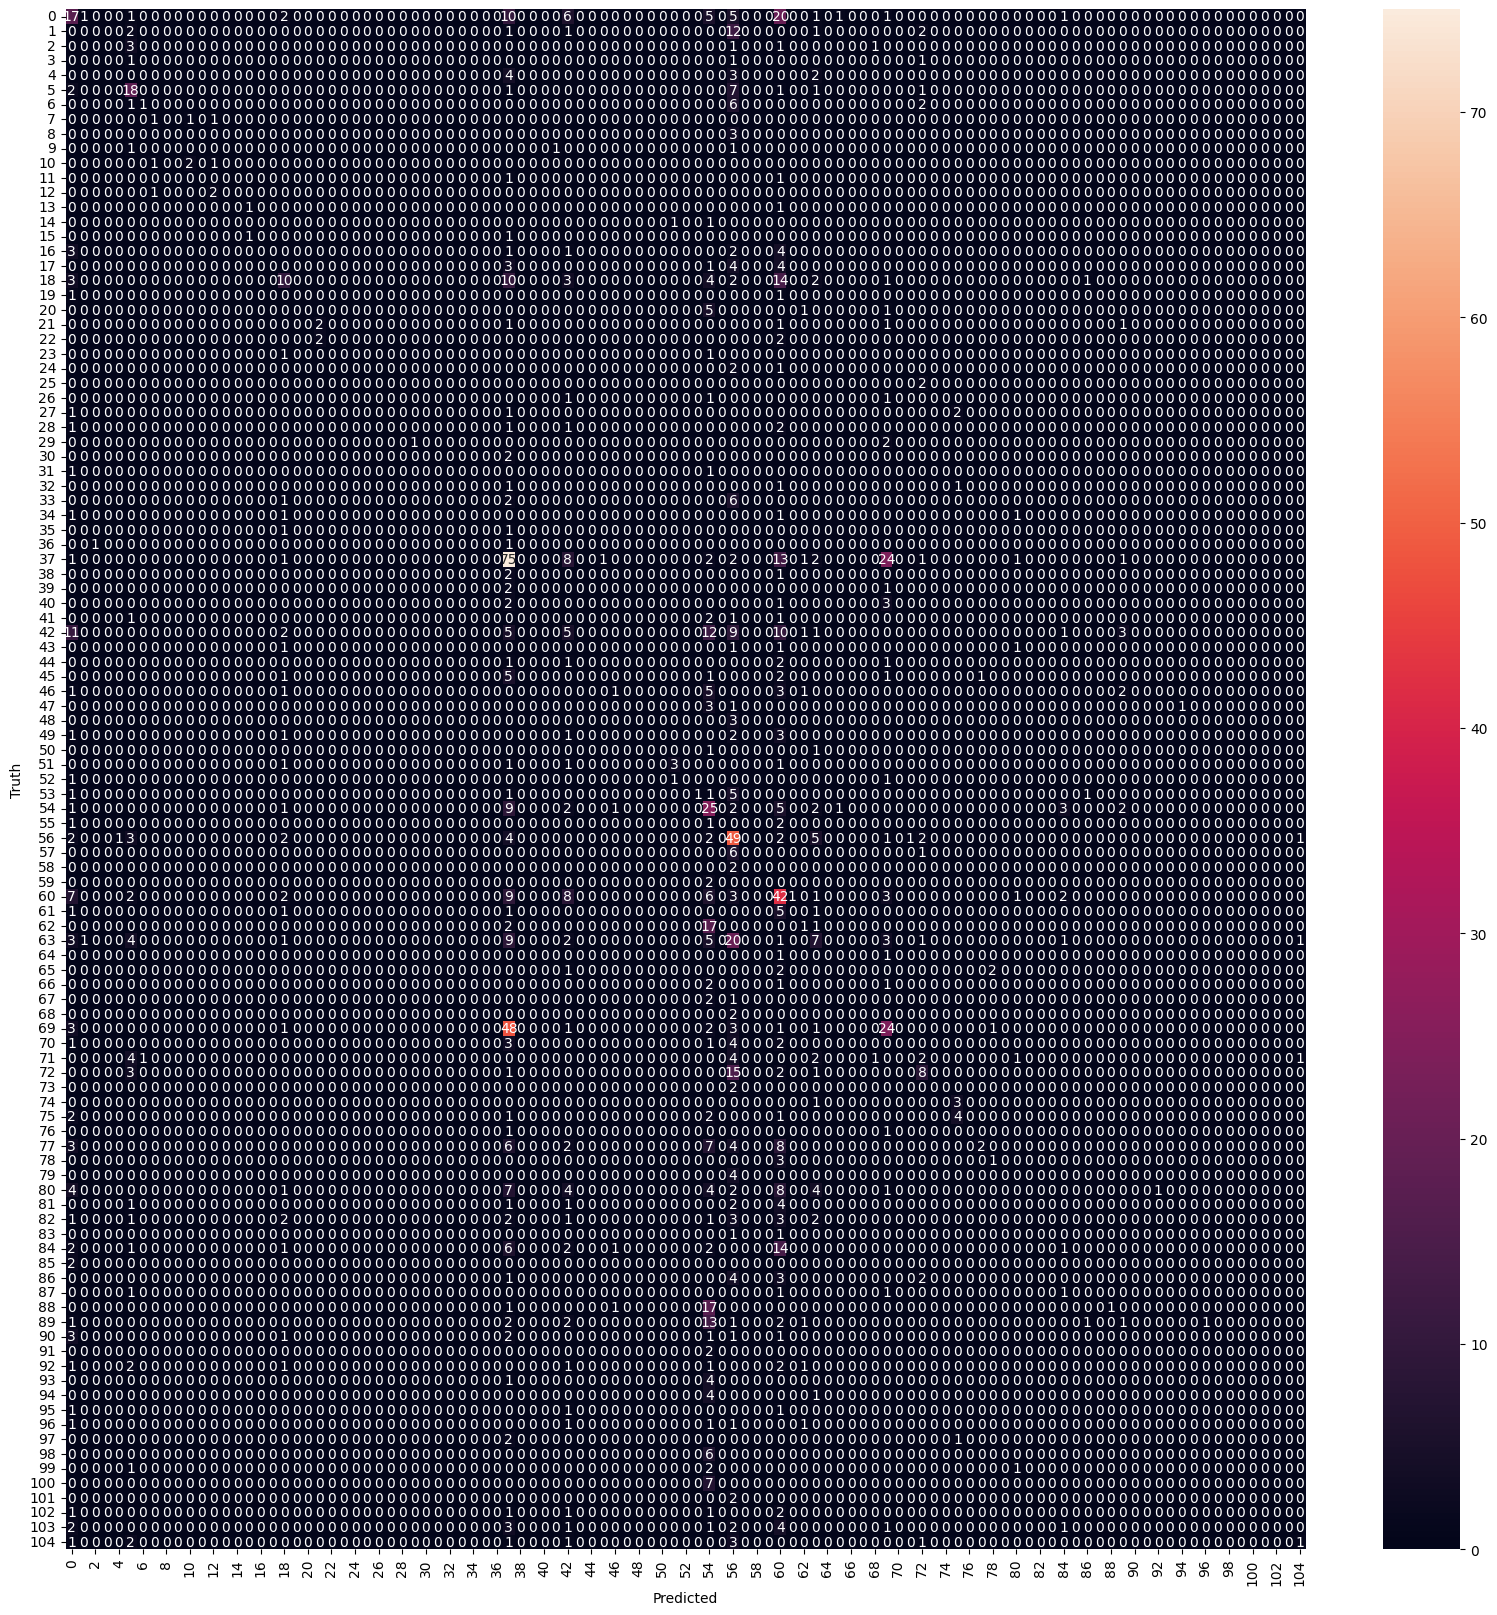

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('20231201_test_confusion_matrix.pdf', format='pdf')
plt.show()

In [34]:
data_df_nomed = data_df_orig[data_df_orig['medium'].isna()]
data_df_nomed.shape

X2 = data_df_nomed.drop('medium', axis=1)
y2 = data_df_nomed['medium']

# Predict on new data
predicted_classes = model.predict(X2)
probabilities = model.predict_proba(X2)  # Probabilities for the positive class

max_indices = np.argmax(probabilities, axis=1)

# Find the max values in each row
max_values = np.max(probabilities, axis=1)

# Combine row IDs, max values, and column IDs
result = np.column_stack((np.arange(probabilities.shape[0]), max_values, max_indices))

#for row in result:
#    print(row)
#    print(f"Row ID: {X2.index.values[int(row[0])]}, Max Value: {row[1]}, Max Value Column ID: {predicted_classes[int(row[2])]}")

predictions = pd.DataFrame(result, columns=['row_id', 'prob_max', 'media_id'])

predictions['row_id'] = predictions['row_id'].apply(lambda x: X2.index.values[int(x)])
predictions['media_id'] = predictions['media_id'].apply(lambda x: predicted_classes[int(x)][0])

predictions = predictions.sort_values(by='prob_max', ascending=False)

predictions = predictions.merge(data_nodes[['id', 'name']], left_on='row_id', right_on='id', how='left')
predictions.rename(columns={'name': 'row_id_label'}, inplace=True)
predictions.drop('id', axis=1, inplace=True)  # Remove the extra 'id' column

# Merge to get media_id_label
predictions = predictions.merge(data_nodes[['id', 'name']], left_on='media_id', right_on='id', how='left')
predictions.rename(columns={'name': 'media_id_label'}, inplace=True)
predictions.drop('id', axis=1, inplace=True)  # Remove the extra 'id' column

def extract_ncbi_id(row_id):
    return row_id.split(':')[-1]

# Function to extract ID after colon for MediaDive link
def extract_media_id(media_id):
    return media_id.split(':')[-1]

# Create the ncbi_link column
predictions['ncbi_link'] = 'https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=' + predictions['row_id'].apply(extract_ncbi_id)

# Create the media_link column
predictions['media_link'] = 'https://mediadive.dsmz.de/medium/' + predictions['media_id'].apply(extract_media_id)

new_column_order = ['row_id', 'media_id', 'prob_max', 'row_id_label', 'media_id_label', 'ncbi_link', 'media_link']

predictions = predictions[new_column_order]

In [35]:
predictions[predictions['prob_max'] > 0.99]

,row_id,media_id,prob_max,row_id_label,media_id_label,ncbi_link,media_link


In [36]:
predictions.to_csv('pred20240110_noembeddings_traingreat9.tsv', sep='\t', index=False)